In [1]:
%matplotlib inline
from matplotlib import style
style.use('seaborn-darkgrid')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# create inspector to engine
inspector = inspect(engine)

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# view Measurement columns
c_measurement = inspector.get_columns('measurement')
for c in c_measurement:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# view Station columns
c_station = inspector.get_columns('station')
for c in c_station:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(Measurement.date)).all()
# changing date format with datetime module
recent_date_dt = dt.datetime.strptime(recent_date[0][0], '%Y-%m-%d')
recent_date_str = dt.datetime.strftime(recent_date_dt, '%B %d, %Y')
print(f'The most recent date is: {recent_date_str}')

The most recent date is: August 23, 2017


In [12]:
recent_date_dt

datetime.datetime(2017, 8, 23, 0, 0)

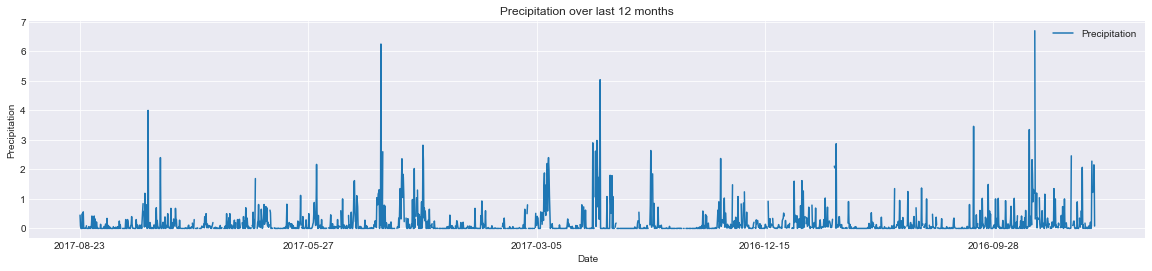

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
date_dif = recent_date_dt - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
last_12_months = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > date_dif).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(last_12_months, columns=['Date', 'Precipitation']).set_index('Date')
# Sort the dataframe by date
df.sort_index(ascending=False, inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(20,4),
        title='Precipitation over last 12 months',
        xlabel='Date',
        ylabel='Precipitation')
plt.show()


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(Measurement.station).distinct().all()
print(f'Total number of stations in the dataset are: {len(stations)} stations')

Total number of stations in the dataset are: 9 stations


In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active = session\
                .query(Measurement.station, func.count(Measurement.station))\
                .group_by(Measurement.station)\
                .order_by(func.count(Measurement.station).desc())\
                .all()

most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

temperatures = session\
                .query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
                .filter(Measurement.station == 'USC00519281')\
                .all()

print(f'The most active station (USC00519281) has the following stats:\n \
        lowest temperature = {temperatures[0][0]}\n \
        highest temperature = {temperatures[0][1]}\n \
        average temperature = {temperatures[0][2]}')

The most active station (USC00519281) has the following stats:
         lowest temperature = 54.0
         highest temperature = 85.0
         average temperature = 71.66378066378067


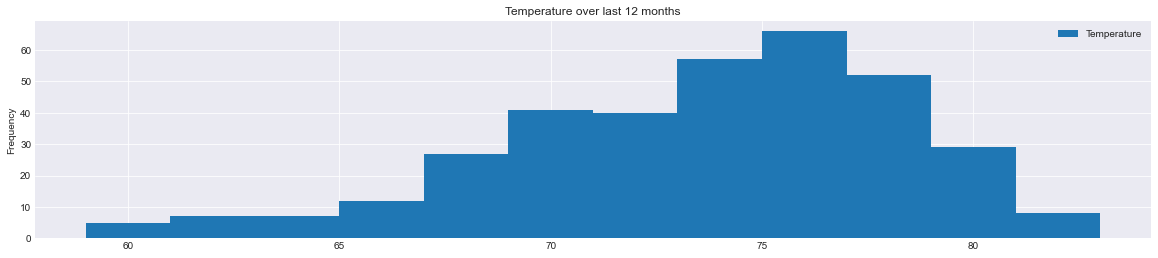

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
USC00519281_12m = session\
                    .query(Measurement.date, Measurement.tobs)\
                    .filter(Measurement.station == 'USC00519281')\
                    .filter(Measurement.date > date_dif)\
                    .all()

# Save the query results as a Pandas DataFrame and set the index to the date column
USC00519281_df = pd.DataFrame(USC00519281_12m, columns=['Date', 'Temperature']).set_index('Date')
# Sort the dataframe by date
USC00519281_df.sort_index(ascending=False, inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
USC00519281_df.plot(figsize=(20,4),
        kind='hist',
        bins=12,
        title='Temperature over last 12 months',
        xlabel='Date',
        ylabel='Temperature')
plt.show()

# Close session

In [20]:
# Close Session
session.close()